<a href="https://colab.research.google.com/github/dmarx/StyleGANXL-CLIP/blob/main/StyleganXL%2BCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **StyleGANXL + CLIP 🖼️**: SlightlyStable edition via DigThatData

## Generate images from text prompts using StyleGANXL with CLIP guidance.

(Modified by Katherine Crowson to optimize in W+ space)

This notebook is a work in progress, head over [here](https://github.com/CasualGANPapers/unconditional-StyleGAN-CLIP) if you want to be up to date with its changes.

Largely based on code by  [Katherine Crowson](https://github.com/crowsonkb) and [nshepperd](https://github.com/nshepperd).

Mostly made possible because of [StyleGAN-XL](https://github.com/autonomousvision/stylegan_xl) and [CLIP](https://github.com/openai/CLIP).

Created by [Eugenio Herrera](https://github.com/ouhenio) and [Rodrigo Mello](https://github.com/ryudrigo).


In [1]:
#@markdown #**Install libraries and define functions** 🏗️🛠️
# @markdown This cell will take a little while because it has to download several libraries.

#@markdown ---

!git clone https://github.com/autonomousvision/stylegan_xl
!git clone https://github.com/openai/CLIP
!git clone https://github.com/crowsonkb/esgd.git
!pip install -e ./CLIP
!pip install einops ninja
!pip install timm

## I'll probably have to trim stuff here

import sys
sys.path.append('./CLIP')
sys.path.append('./stylegan_xl')
sys.path.append('./esgd')

import io
import os, time, glob
import pickle
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import clip
import unicodedata
import re
from esgd import ESGD
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from google.colab import files
import dnnlib
import legacy


device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

# Functions (many must be trimmed too)

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def fetch_model(url_or_path):
    !wget -c '{url_or_path}'

def slugify(value, allow_unicode=False):
    """
    Taken from https://github.com/django/django/blob/master/django/utils/text.py
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

def norm1(prompt):
    "Normalize to the unit sphere."
    return prompt / prompt.square().sum(dim=-1,keepdim=True).sqrt()

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

def prompts_dist_loss(x, targets, loss):
    if len(targets) == 1: # Keeps consitent results vs previous method for single objective guidance 
      return loss(x, targets[0])
    distances = [loss(x, target) for target in targets]
    return torch.stack(distances, dim=-1).sum(dim=-1)  

class MakeCutouts(torch.nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)

make_cutouts = MakeCutouts(224, 32, 0.5)

def embed_image(image):
  n = image.shape[0]
  cutouts = make_cutouts(image)
  embeds = clip_model.embed_cutout(cutouts)
  embeds = rearrange(embeds, '(cc n) c -> cc n c', n=n)
  return embeds

def embed_url(url):
  image = Image.open(fetch(url)).convert('RGB')
  return embed_image(TF.to_tensor(image).to(device).unsqueeze(0)).mean(0).squeeze(0)

class CLIP(object):
  def __init__(self):
    clip_model = "ViT-B/16"
    self.model, _ = clip.load(clip_model)
    self.model = self.model.requires_grad_(False)
    self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                          std=[0.26862954, 0.26130258, 0.27577711])

  @torch.no_grad()
  def embed_text(self, prompt):
      "Normalized clip text embedding."
      return norm1(self.model.encode_text(clip.tokenize(prompt).to(device)).float())

  def embed_cutout(self, image):
      "Normalized clip image embedding."
      return norm1(self.model.encode_image(self.normalize(image)))
  
clip_model = CLIP()

Cloning into 'stylegan_xl'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 298 (delta 75), reused 58 (delta 44), pack-reused 192
Receiving objects: 100% (298/298), 13.89 MiB | 21.00 MiB/s, done.
Resolving deltas: 100% (134/134), done.
Cloning into 'CLIP'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 229 (delta 1), reused 1 (delta 0), pack-reused 222
Receiving objects: 100% (229/229), 8.92 MiB | 21.00 MiB/s, done.
Resolving deltas: 100% (112/112), done.
Cloning into 'esgd'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 29 (delta 10), reused 27 (delta 8), pack-reused 0
Unpacking objects: 100% (29/29), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

Using device: cuda:0
100%|███████████████████████████████████████| 335M/335M [00:04<00:00, 84.1MiB/s]


In [2]:
%%capture

# just use the machinery in pytti for now
# super bloated installation relative to what we need


# { display-mode: 'form' }


## 1. Install stuff

try: 
    import pytti
except ImportError:
    !pip install kornia pytorch-lightning transformers
    !pip install jupyter loguru einops PyGLM ftfy regex tqdm hydra-core exrex
    !pip install seaborn adjustText bunch matplotlib-label-lines
    !pip install --upgrade gdown

    !pip install --upgrade git+https://github.com/pytti-tools/AdaBins.git
    !pip install --upgrade git+https://github.com/pytti-tools/GMA.git
    !pip install --upgrade git+https://github.com/pytti-tools/taming-transformers.git
    !pip install --upgrade git+https://github.com/openai/CLIP.git
    !pip install --upgrade git+https://github.com/pytti-tools/pytti-core.git

    # These are notebook specific
    !pip install --upgrade natsort

try:
    import mmc
except:
    # install mmc
    !git clone https://github.com/dmarx/Multi-Modal-Comparators
    !pip install poetry
    !cd Multi-Modal-Comparators; poetry build
    !cd Multi-Modal-Comparators; pip install dist/mmc*.whl
    !python Multi-Modal-Comparators/src/mmc/napm_installs/__init__.py

from natsort import natsorted
from omegaconf import OmegaConf
from pathlib import Path

import mmc.loaders
!python -m pytti.warmup

notebook_params = {}

def get_output_paths():
    outv = [str(p.resolve()) for p in Path('outputs/').glob('**/*.png')]
    #outv.sort()
    outv = natsorted(outv)
    return outv

In [3]:
import PIL

from pytti.LossAug.OpticalFlowLossClass import (
    init_GMA,
    OpticalFlowLoss,
)

init_GMA() 

#flow_forward = OpticalFlowLoss.get_flow(image1, image2, device=device)
#flow_backward = OpticalFlowLoss.get_flow(image2, image1, device=device)

#fancy_mask = OpticalFlowLoss.motion_edge_map(
#    flow_forward, flow_backward, 
#    # this function doesn't do anythign with any of these three arguments
#    img=None,
#    border_mode=None,
#    sampling_mode=None,
#)


import numpy as np


def flow_to_image(flow):
    """
    Convert flow into middlebury color code image
    :param flow: optical flow map
    :return: optical flow image in middlebury color
    """
    UNKNOWN_FLOW_THRESH = 1e7

    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.0
    maxv = -999.0
    minu = 999.0
    minv = 999.0

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u**2 + v**2)
    maxrad = max(-1, np.max(rad))

    u = u / (maxrad + np.finfo(float).eps)
    v = v / (maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)


def compute_color(u, v):
    """
    compute optical flow color map
    :param u: optical flow horizontal map
    :param v: optical flow vertical map
    :return: optical flow in color code
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2 + v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a + 1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols + 1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel, 1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0 - 1] / 255
        col1 = tmp[k1 - 1] / 255
        col = (1 - f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col * (1 - nanIdx)))

    return img


def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0
    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255 * np.arange(0, RY) / RY))
    col += RY
    # YG
    colorwheel[col : col + YG, 0] = 255 - np.transpose(np.floor(255 * np.arange(0, YG) / YG))
    colorwheel[col : col + YG, 1] = 255
    col += YG
    # GC
    colorwheel[col : col + GC, 1] = 255
    colorwheel[col : col + GC, 2] = np.transpose(np.floor(255 * np.arange(0, GC) / GC))
    col += GC
    # CB
    colorwheel[col : col + CB, 1] = 255 - np.transpose(np.floor(255 * np.arange(0, CB) / CB))
    colorwheel[col : col + CB, 2] = 255
    col += CB
    # BM
    colorwheel[col : col + BM, 2] = 255
    colorwheel[col : col + BM, 0] = np.transpose(np.floor(255 * np.arange(0, BM) / BM))
    col += +BM
    # MR
    colorwheel[col : col + MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col : col + MR, 0] = 255

    return colorwheel

def flow2pil(flow):
  im = transforms.ToPILImage()(flow).convert("RGB")
  return im

In [17]:
#@markdown #**Optional:** Save images in Google Drive 💾
# @markdown Run this cell if you want to store the results inside Google Drive.

# @markdown Copying the generated images to drive is faster to work with.

# @markdown **Important**: you must have a folder named *samples* inside your drive, otherwise this may not work.

#@markdown ---

# Uncomment to copy generated images to drive, faster than downloading directly from colab in my experience.

mount_drive = False # @param {type:'boolean'}
if mount_drive:
  from google.colab import drive
  drive.mount('/content/drive')

In [18]:
#@markdown #**Model selection** 🎭

Model = 'Imagenet-1024' #@param ["Imagenet-1024", "Imagenet-512", "Imagenet-256", "Imagenet-128", "Pokemon", "FFHQ"]

#@markdown ---

network_url = {
    "Imagenet-1024": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet1024.pkl",
    "Imagenet-512": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet512.pkl",
    "Imagenet-256": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet256.pkl",
    "Imagenet-128": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet128.pkl",
    "Pokemon-1024": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon1024.pkl",
    "Pokemon-512": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon512.pkl",
    "Pokemon-256": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon256.pkl",
    "FFHQ-256": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/ffhq256.pkl"
}

network_name = network_url[Model].split("/")[-1]
fetch_model(network_url[Model])

with dnnlib.util.open_url(network_name) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore


zs = torch.randn([10000, G.mapping.z_dim], device=device)
cs = torch.zeros([10000, G.mapping.c_dim], device=device)
for i in range(cs.shape[0]):
  cs[i,i//10]=1
w_stds = G.mapping(zs, cs)
w_stds = w_stds.reshape(10, 1000, G.num_ws, -1)
w_stds=w_stds.std(0).mean(0)[0]
w_all_classes_avg = G.mapping.w_avg.mean(0)

aggressive_stabilization = False  # @param {type:'boolean'}

dejiggle_weight=100 # @param {type:'number'}

ema_decay = 0.5 # @param {type:'number'}

if aggressive_stabilization:
  dejiggle_weight = 0

#####################################################
# stabilization snippet via @PDillis
# https://twitter.com/PDillis/status/1551673599878209544
if hasattr(G.synthesis, 'input') and aggressive_stabilization:
    if G.c_dim == 0:
        shift = (G
            .synthesis
            .input
            .affine(G.mapping.w_avg.unsqueeze(0))
            .squeeze(0)
        )
    else:
        shift = (G
            .synthesis
            .input
            .affine(G.mapping.w_avg)
            .mean(0)
        )
    G.synthesis.input.affine.bias.data.add_(shift)
    G.synthesis.input.affine.weight.data.zero_()
#####################################################

--2022-07-26 23:32:57--  https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet1024.pkl
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.171.133
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.171.133|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



  0%|          | 0/360 [00:00<?, ?it/s]

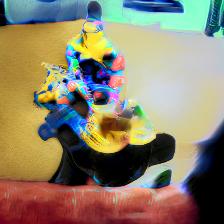

Image 0/360 | Current loss: 0.8857784867286682


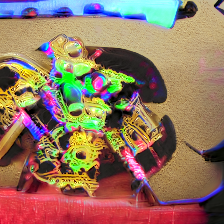

Image 10/360 | Current loss: 5550.22998046875


In [ ]:
#@markdown #**Run the model** 🚀
#@markdown `texts`: Enter here a prompt to guide the image generation. You can enter more than one prompt separated with
#@markdown `|`, which will cause the guidance to focus on the different prompts at the same time, allowing to mix and play
#@markdown with the generation process.

#@markdown `steps`: Number of optimization steps. The more steps, the longer it will try to generate an image relevant to the prompt.

#@markdown `seed`: Determines the randomness seed. Using the same seed and prompt should give you similar results at every run.
#@markdown Use `-1` for a random seed.

#@markdown ---

import einops as ei


#texts = "the loom of the gods" #@param {type:"string"}
texts = "steampunk laser dance party" #@param {type:"string"}
steps = 360 #@param {type:"number"}
warmup_steps = 50
seed = 12345#@param {type:"number"}
save_every = 2 #@param {type:"number"}

#@markdown ---

if seed == -1:
    seed = np.random.randint(0,9e9)
    print(f"Your random seed is: {seed}")

texts = [frase.strip() for frase in texts.split("|") if frase]

targets = [clip_model.embed_text(text) for text in texts]


'''
zs = torch.randn([10000, G.mapping.z_dim], device=device)
one_hot_class = torch.zeros(1000)
initial_class = torch.randint(0,1000, (1,))[0]
one_hot_class[initial_class]=1
one_hot_class = one_hot_class.repeat((10000, 1))
cs = one_hot_class.to(device)
w_stds = G.mapping(zs, cs)
w_stds=w_stds.std(0)[0]
'''




tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
])

initial_batch=4 #actually that will be multiplied by initial_image_steps
initial_image_steps=warmup_steps
'''
c = torch.zeros((1000)) #just to pick a closer initial image
c[initial_class]=1
c = c.repeat(initial_batch, 1)
c=c.to(device)
'''
def run(timestring):
  flow=None
  torch.manual_seed(seed)
  with torch.no_grad():
    qs = []
    losses = []
    for _ in range(initial_image_steps):
      a = torch.randn([initial_batch, 512], device=device)*0.6 + w_all_classes_avg*0.4
      q = ((a-w_all_classes_avg)/w_stds)
      images = G.synthesis((q * w_stds + w_all_classes_avg).unsqueeze(1).repeat([1, G.num_ws, 1]))
      embeds = embed_image(images.add(1).div(2))
      loss = prompts_dist_loss(embeds, targets, spherical_dist_loss).mean(0)
      i = torch.argmin(loss)
      qs.append(q[i])
      losses.append(loss[i])
    qs = torch.stack(qs)
    losses = torch.stack(losses)
    i = torch.argmin(losses)
    q = qs[i].unsqueeze(0).repeat([G.num_ws, 1]).requires_grad_()
    # print(q)
    # q = qs[i].unsqueeze(0).repeat([G.num_ws, 1])
    # q = torch.tensor(q, requires_grad=True)
    # print(q)

  im_prev=None
  # Sampling loop
  q_ema = q
  # print(q.shape)
  # opt = ESGD([q], lr=0.03, betas=(0.9, 0.999), nu=0.9)
  opt = torch.optim.AdamW([q], lr=0.03, betas=(0., 0.999), weight_decay=0.025)
  loop = tqdm(range(steps))
  for i in loop:
    opt.zero_grad()

    w = q * w_stds
    image = G.synthesis((q * w_stds + w_all_classes_avg)[None], noise_mode='const')
    embed = embed_image(image.add(1).div(2))
    loss = prompts_dist_loss(embed, targets, spherical_dist_loss).mean()

    ##############
    # de-jiggle loss
    if (im_prev is not None) and (dejiggle_weight != 0):
        flow = OpticalFlowLoss.get_flow(im_prev, image)
        net_flow = flow.mean()
        loss += dejiggle_weight * net_flow

    ##############
    # loss.backward(create_graph=opt.should_create_graph())
    loss.backward()
    opt.step()
    loop.set_postfix(loss=loss.item(), q_magnitude=q.std().item())

    q_ema = q_ema * (1-ema_decay) + q * ema_decay
    image = G.synthesis((q_ema * w_stds + w_all_classes_avg)[None],
                        noise_mode='const',                        
                        )

    if i % save_every == 0:
      with torch.no_grad():
        im_prev = image.clone().detach()
      if i % 10 == 0 or i == (steps - 1):
        display(TF.to_pil_image(tf(image)[0]))
        print(f"Image {i}/{steps} | Current loss: {loss}")
        #####################
        #if flow is not None:
        #  im_t_flow_fwd = ei.rearrange(flow, 'b c h w -> b h w c')
        #  arr_flow_fwd = flow_to_image(im_t_flow_fwd.squeeze().detach().clone().cpu().numpy())
        #  display(flow2pil(arr_flow_fwd))

      pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
      os.makedirs(f'samples/{timestring}', exist_ok=True)
      pil_image.save(f'samples/{timestring}/{i:04}.jpg')

try:
  timestring = time.strftime('%Y%m%d%H%M%S')
  run(timestring)
except KeyboardInterrupt:
  pass

In [20]:
#@markdown #**Generate video** 🎥

#@markdown You can edit frame rate and stuff by double-clicking this tab.

frames = os.listdir(f"samples/{timestring}")
frames = len(list(filter(lambda filename: filename.endswith(".jpg"), frames))) #Get number of jpg generated

init_frame = 1 #This is the frame where the video will start
last_frame = frames #You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.

min_fps = 10
max_fps = 60

total_frames = last_frame-init_frame

#Desired video time in seconds
video_length =  12#@param {type:"number"}
#Video filename
video_name = "caffeinated" #@param {type:"string"}
video_name = slugify(video_name)

if not video_name:
  video_name = "video"
# frames = []
# tqdm.write('Generating video...')
# for i in range(init_frame,last_frame): #
#     filename = f"samples/{timestring}/{i:04}.jpg"
#     frames.append(Image.open(filename))

fps = np.clip(total_frames/video_length,min_fps,max_fps)

print("Generating video...")
!ffmpeg -r {fps} -i samples/{timestring}/%04d.jpg -c:v libx264 -vf fps={fps} -pix_fmt yuv420p samples/{video_name}.mp4 -frames:v {total_frames}

# from subprocess import Popen, PIPE
# p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p', '-crf', '17', '-preset', 'veryslow', f'samples/{video_name}.mp4'], stdin=PIPE)
# for im in tqdm(frames):
#     im.save(p.stdin, 'PNG')
# p.stdin.close()

print("The video is ready")

Generating video...
ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable

In [21]:
#@markdown #**Download video** 📀
#@markdown If you're activated the download to GDrive option, the video will be save there. Don't worry about overwritting issues for colliding filenames, an id will be added to them to avoid this.

#Video filename
to_download_video_name = "caffeinated" #@param {type:"string"}
to_download_video_name = slugify(to_download_video_name)

if not to_download_video_name:
  to_download_video_name = "video"


from google.colab import files
if os.path.isdir('drive/MyDrive/samples'):
  filelist = glob.glob(f'drive/MyDrive/samples/{to_download_video_name}*.mp4')
  video_count = len(filelist)
  if video_count:
    final_video_name = f"{to_download_video_name}{video_count}"
  else:
    final_video_name = to_download_video_name
  shutil.copyfile(f'samples/{video_name}.mp4', f'drive/MyDrive/samples/{final_video_name}.mp4')
else:
  files.download(f"samples/{to_download_video_name}.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>